### Стандартные импорты и настройки

In [1]:
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Scipy

Импортируем функции из библиотеки для кластеризации и векторного квантования.

https://docs.scipy.org/doc/scipy-0.18.1/reference/cluster.vq.html

In [2]:
from scipy.cluster.vq import whiten, kmeans2

### Подключаем API

Для примера используем открытое API, которое предоставляет данные о футбольных командах и матчах. 

http://api.football-data.org/docs/v1/index.html

Для полноценного использования лучше всего получить ключ, это довольно просто.

http://api.football-data.org/register

Для удобства зададим вспомогательный метод для обращения к API.

In [3]:
def call_api(uri, result_key):
    json = {}
    try:
        json = requests.get(uri, headers = { 'X-Auth-Token': 'c52b7825851b4357af3e06c1888152f0' }).json()
        return json[result_key]
    except:
        print(json)
        return None

Получаем команды

In [4]:
teams = call_api('http://api.football-data.org/v1/soccerseasons/439/teams', 'teams')
teams

[{'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/496/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/496/players'},
   'self': {'href': 'http://api.football-data.org/v1/teams/496'}},
  'code': None,
  'crestUrl': 'http://upload.wikimedia.org/wikipedia/de/6/63/Rio_Ave_FC.svg',
  'name': 'FC Rio Ave',
  'shortName': 'Rio Ave',
  'squadMarketValue': '21,125,000 €'},
 {'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/503/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/503/players'},
   'self': {'href': 'http://api.football-data.org/v1/teams/503'}},
  'code': 'FCP',
  'crestUrl': 'http://upload.wikimedia.org/wikipedia/de/e/ed/FC_Porto_1922-2005.svg',
  'name': 'FC Porto',
  'shortName': 'Porto',
  'squadMarketValue': '204,900,000 €'},
 {'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/583/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/583/players

Для каждой команды получаем игроков и игры.

In [5]:
for team in teams:
    players = call_api(team['_links']['players']['href'], 'players')
    fixtures = call_api(team['_links']['fixtures']['href'], 'fixtures')
    wins = 0
    for f in fixtures:
        if team['name'] == f['homeTeamName']:
            wins += f['result']['goalsHomeTeam'] if f['result']['goalsHomeTeam'] else 0
        else:
            wins += f['result']['goalsAwayTeam'] if f['result']['goalsAwayTeam'] else 0
    print('Team "{}", {} players, {} wins'.format(team['name'], len(players), wins))
    team['players'] = players
    team['wins'] = wins

Team "FC Rio Ave", 26 players, 21 wins
Team "FC Porto", 29 players, 44 wins
Team "Moreirense FC", 25 players, 15 wins
Team "FC Paços de Ferreira", 27 players, 17 wins
Team "Sporting CP", 30 players, 34 wins
Team "Maritimo Funchal", 34 players, 15 wins
Team "CD Tondela", 29 players, 13 wins
Team "SL Benfica", 30 players, 47 wins
Team "Boavista Porto FC", 36 players, 20 wins
Team "FC Arouca", 26 players, 17 wins
Team "Vitoria Setubal", 34 players, 17 wins
Team "C.F. Os Belenenses", 29 players, 11 wins
Team "Vitoria Guimaraes", 27 players, 27 wins
Team "Sporting Braga", 33 players, 27 wins
Team "GD Estoril Praia", 26 players, 12 wins
Team "Feirense", 0 players, 13 wins
Team "Nacional Funchal", 26 players, 14 wins
Team "G.D. Chaves", 0 players, 19 wins


Готовим данные для трансформации в Pandas

In [6]:
team_for_pd = []
for team in teams:
    if team['players']:
        team_for_pd.append({'name': team['name'], 'players': len(team['players']), 'wins': team['wins']})
team_for_pd

[{'name': 'FC Rio Ave', 'players': 26, 'wins': 21},
 {'name': 'FC Porto', 'players': 29, 'wins': 44},
 {'name': 'Moreirense FC', 'players': 25, 'wins': 15},
 {'name': 'FC Paços de Ferreira', 'players': 27, 'wins': 17},
 {'name': 'Sporting CP', 'players': 30, 'wins': 34},
 {'name': 'Maritimo Funchal', 'players': 34, 'wins': 15},
 {'name': 'CD Tondela', 'players': 29, 'wins': 13},
 {'name': 'SL Benfica', 'players': 30, 'wins': 47},
 {'name': 'Boavista Porto FC', 'players': 36, 'wins': 20},
 {'name': 'FC Arouca', 'players': 26, 'wins': 17},
 {'name': 'Vitoria Setubal', 'players': 34, 'wins': 17},
 {'name': 'C.F. Os Belenenses', 'players': 29, 'wins': 11},
 {'name': 'Vitoria Guimaraes', 'players': 27, 'wins': 27},
 {'name': 'Sporting Braga', 'players': 33, 'wins': 27},
 {'name': 'GD Estoril Praia', 'players': 26, 'wins': 12},
 {'name': 'Nacional Funchal', 'players': 26, 'wins': 14}]

Трансформируем

In [7]:
teams_pd = pd.DataFrame(team_for_pd)
teams_pd

,name,players,wins
0,FC Rio Ave,26,21
1,FC Porto,29,44
2,Moreirense FC,25,15
3,FC Paços de Ferreira,27,17
4,Sporting CP,30,34
5,Maritimo Funchal,34,15
6,CD Tondela,29,13
7,SL Benfica,30,47
8,Boavista Porto FC,36,20
9,FC Arouca,26,17


Отображаем

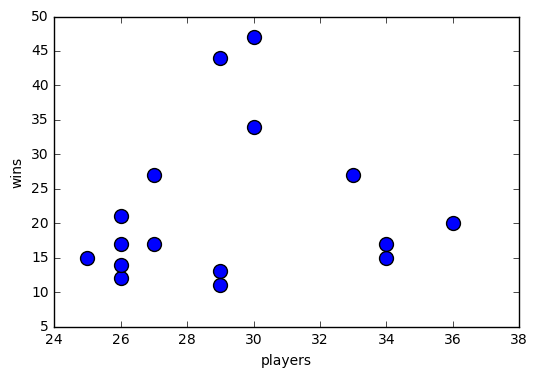

In [8]:
teams_pd.plot.scatter(x='players', y='wins', s=100)

Удаляем колонку с именами

In [9]:
del teams_pd['name']
teams_pd

,players,wins
0,26,21
1,29,44
2,25,15
3,27,17
4,30,34
5,34,15
6,29,13
7,30,47
8,36,20
9,26,17


Нормализация данных

In [10]:
whitened = whiten(teams_pd.as_matrix())
whitened

array([[  7.82956964,   1.95457881],
       [  8.73298153,   4.09530799],
       [  7.52843235,   1.39612772],
       [  8.13070694,   1.58227809],
       [  9.03411882,   3.16455617],
       [ 10.238668  ,   1.39612772],
       [  8.73298153,   1.20997736],
       [  9.03411882,   4.37453353],
       [ 10.84094259,   1.86150363],
       [  7.82956964,   1.58227809],
       [ 10.238668  ,   1.58227809],
       [  8.73298153,   1.023827  ],
       [  8.13070694,   2.5130299 ],
       [  9.9375307 ,   2.5130299 ],
       [  7.82956964,   1.11690218],
       [  7.82956964,   1.30305254]])

Сделаем 3 кластера

In [11]:
centroids, cluster_map = kmeans2(whitened, 3)
centroids, cluster_map

(array([[ 10.31395232,   1.83823483],
        [  8.93373972,   3.87813256],
        [  8.06378754,   1.52022796]]),
 array([2, 1, 2, 2, 1, 0, 2, 1, 0, 2, 0, 2, 2, 0, 2, 2], dtype=int32))

Зададим цвета для каждого кластера

In [12]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]
colors

['b',
 'g',
 'b',
 'b',
 'g',
 'r',
 'b',
 'g',
 'r',
 'b',
 'r',
 'b',
 'b',
 'r',
 'b',
 'b']

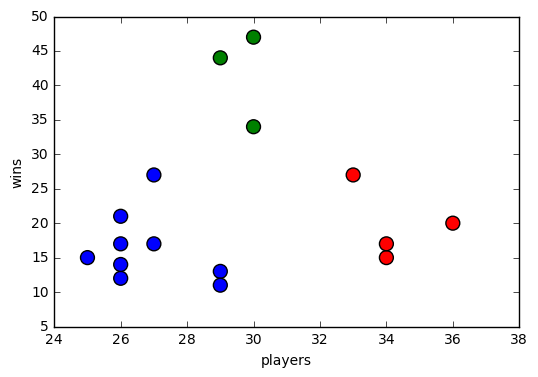

In [13]:
teams_pd.plot.scatter(x='players', y='wins', c=colors, s=100)

Теперь попробуем сделать больше кластеров.

In [19]:
centroids, cluster_map = kmeans2(whitened, 5)
centroids, cluster_map

(array([[  8.73298153,   1.11690218],
        [  7.82956964,   1.39612772],
        [  8.93373972,   3.87813256],
        [ 10.31395232,   1.83823483],
        [  7.98013829,   2.23380436]]),
 array([4, 2, 1, 1, 2, 3, 0, 2, 3, 1, 3, 0, 4, 3, 1, 1], dtype=int32))

In [20]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]
colors

['m',
 'b',
 'g',
 'g',
 'b',
 'y',
 'r',
 'b',
 'y',
 'g',
 'y',
 'r',
 'm',
 'y',
 'g',
 'g']

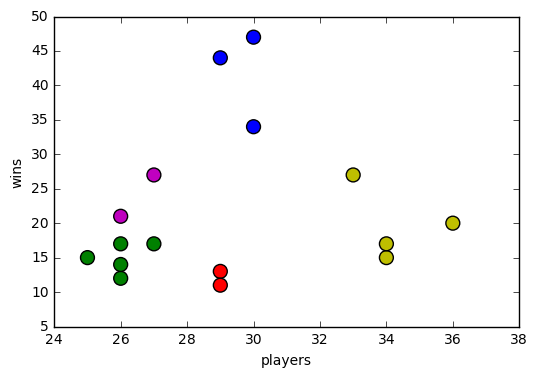

In [21]:
teams_pd.plot.scatter(x='players', y='wins', c=colors, s=100)